In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, logging_outputs

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import scipy.io
%matplotlib inline

# 1. Data Preprocessing and Importing

In [5]:
full_dataset=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='allSubjectsWithKANA_AALVolumes').drop('ID',axis=1)
full_dataset=full_dataset.rename({'Subject':'ID'},axis=1)

In [6]:
print('volumetric dataset')
full_dataset.head(5)

volumetric dataset


,ID,Session,GA at birth,PMA at birth,17 ICV (all except bone),17 TOTAL BRAIN TISSUE VOLUME (mm3),"19 Volume Pallidum (Bilateral) AAL, careful with preterm","28 Volume Mesencephalon (right cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (left cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (vermis) (AAL, careful with preterm!)",...,Imperial 78,Imperial 79,Imperial 80,Imperial 81,Imperial 82,Imperial 83,Imperial 84,Imperial 85,Imperial 86,Imperial 87
0,CC00050XX01,7201,43.000000,43.285714,538834.125,416535.500,1492.250,11235.750,10877.875,3002.625,...,1626.125,31817.250,31494.500,17666.125,17229.625,116503.625,56730.125,8424.000,590.500,644.875
1,CC00051XX02,7702,39.857143,40.000000,408434.000,331495.375,1271.750,7671.875,7308.500,2321.000,...,1122.750,28027.000,27600.750,15869.875,15364.750,73673.875,52764.000,7013.500,449.250,456.250
2,CC00052XX03,8300,38.000000,38.714286,402194.750,338127.375,1335.875,7779.500,7386.500,2105.250,...,1109.625,29074.000,29272.625,17240.625,16389.750,60055.750,44432.875,7256.125,331.375,328.750
3,CC00053XX04,8607,40.000000,40.428571,385670.625,308055.000,1230.125,8317.250,8035.500,2337.625,...,996.125,22724.625,22801.875,13682.250,14212.125,71222.625,43329.375,6966.625,397.000,395.500
4,CC00054XX05,8800,41.857143,42.142857,424075.500,346738.625,1370.375,8875.875,8428.125,2378.875,...,1354.750,27762.750,28165.625,16663.750,16885.750,74110.625,48786.500,7033.750,459.250,465.125


In [7]:
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [8]:
diffusion_full_dataset=scipy.io.loadmat('./dataset/diff_dataset/2020_04_MASTER_connectomes90_433subj_SCandFC_TermScansVolOK.mat')
diffusion_matrices=diffusion_full_dataset['SCmu']#use the Structural Connectivity (SIFT2-weighted * Mu) [equivalent to raw connectivity, see SIFT2 paper]
diffusion_matrices=[diffusion_matrices[:,:,i] for i in range(diffusion_matrices.shape[2])] # rearranged them into (433,90,90)
diffusion_matrices=np.asarray(diffusion_matrices)

In [9]:
diffusion_matrices=np.asarray([data_preprocessing.lower_triangle(diffusion_matrices[i]) for i in range(diffusion_matrices.shape[0])])
diffusion_matrices=pd.DataFrame(diffusion_matrices)

In [10]:
diffusion_matrices.columns=data_preprocessing.lower_triangle(ROIs_combinations)

In [11]:
diffusion_subject_id=diffusion_full_dataset['sub'].reshape(-1,1)
diffusion_subject_id=[i[0][0].replace('sub-','') for i in diffusion_subject_id]
diffusion_subject_sess=diffusion_full_dataset['ses'].reshape(-1,1)
diffusion_subject_sess=[i[0][0].replace('ses-','') for i in diffusion_subject_sess]
diffusion_subject_pma=diffusion_full_dataset['pma'].reshape(-1)
diffusion_subject_ga=diffusion_full_dataset['ga'].reshape(-1)
#1 Male/ 2 Female
diffusion_subject_gender=diffusion_full_dataset['sex'].reshape(-1)
diffusion_dataset=pd.DataFrame({'ID':diffusion_subject_id,
'Session':diffusion_subject_sess,'Gender':diffusion_subject_gender,
'GA':diffusion_subject_ga,'PMA':diffusion_subject_pma})
#match the ID to the diffusion matrices
diffusion_dataset=pd.concat((diffusion_dataset,diffusion_matrices),axis=1)
#rearrange by the session, drop the duplicates and keep the last session
diffusion_dataset=diffusion_dataset.sort_values(by='Session',ascending=False)
diffusion_dataset=diffusion_dataset.drop_duplicates(subset='ID',keep='last')
diffusion_dataset=diffusion_dataset.reset_index(drop=True)


In [12]:
print('diffusion dataset')
diffusion_dataset.head(5)

diffusion dataset


,ID,Session,Gender,GA,PMA,PreCG.R_PreCG.L,SFGdor.L_PreCG.L,SFGdor.L_PreCG.R,SFGdor.R_PreCG.L,SFGdor.R_PreCG.R,...,ITG.R_HES.R,ITG.R_STG.L,ITG.R_STG.R,ITG.R_TPOsup.L,ITG.R_TPOsup.R,ITG.R_MTG.L,ITG.R_MTG.R,ITG.R_TPOmid.L,ITG.R_TPOmid.R,ITG.R_ITG.L
0,CC00309BN12,99400,1,27.142857,43.571429,0.110269,2.734645,0.022175,0.053020,2.703169,...,0.027096,0.000328,0.553082,0.000000,1.354229,0.000269,9.224019,0.000000,3.536425,0.000000
1,CC00308XX11,98900,2,37.285714,37.428571,0.070403,1.424295,0.028932,0.054429,1.604058,...,0.015710,0.000247,0.512309,0.000378,1.462916,0.000916,6.572805,0.000224,1.907144,0.000534
2,CC00306XX09,98700,1,39.714286,40.285714,0.146737,2.298130,0.040217,0.118238,2.568366,...,0.028501,0.000093,0.710438,0.000075,1.410843,0.000321,8.158628,0.000263,2.735754,0.000335
3,CC00303XX06,96900,1,40.000000,43.428571,0.035978,2.288692,0.025000,0.055896,2.960535,...,0.040646,0.000059,2.271606,0.000000,0.733402,0.000172,16.157624,0.000000,3.695710,0.000050
4,CC00300XX03,96000,1,40.857143,41.000000,0.070895,2.382008,0.040690,0.057860,2.498296,...,0.007220,0.000317,0.464629,0.000314,1.537647,0.000274,5.961699,0.000120,2.654921,0.000049


In [13]:
Imperial_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='IMPERIAL ROIs LEGEND',header=None).drop([0,1],axis=1)
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)

In [14]:
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label=np.asarray([str.strip(i.translate({ord(c): None for c in digits})) for i in (np.asarray(Imperial_label)).reshape(-1)])

In [15]:
#Reading necessary tables
schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ2_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',add_EP=False)
ancestral_PCA_european=data_preprocessing.read_table_from_txt('./dataset/file3_only_europ_10pcs_pca.eigenvec',add_EP=False)

In [16]:
ancestral_PCA_european.columns=['ID','Anc_PC1','Anc_PC2','Anc_PC3','Anc_PC4','Anc_PC5', 'Anc_PC6', 'Anc_PC7', 'Anc_PC8', 'Anc_PC9',
       'Anc_PC10']

In [17]:
#Merge the tables together using the european ID as the key.
from functools import reduce
european_ID_dataset=reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'),[full_dataset,schizophrenia_high_scores_european,ancestral_PCA_european])
#retain the last session in cases of duplication
european_ID_dataset=european_ID_dataset.drop_duplicates(subset='ID',keep='last')
european_ID_dataset=european_ID_dataset.reset_index(drop=True)


In [18]:
#adding diffusion dataset to the european_ID dataset
european_ID_dataset=pd.merge(diffusion_dataset,european_ID_dataset,how='right',on='ID')
#Session, GA and PMA are the same between the volumetric and diffusion dataset
european_ID_dataset=european_ID_dataset.drop(european_ID_dataset.columns[np.r_[1,3:5]],axis=1)
#rearranging the data frame to look better
european_ID_dataset=data_preprocessing.move_multiple_columns(european_ID_dataset,cols_to_move=['Session_y','Gender','GA at birth','PMA at birth'],ref_col='ID',place='After')

In [19]:
print('European diffusion dataset')
print(european_ID_dataset.shape)
(european_ID_dataset.head(5))

European diffusion dataset
(269, 4228)


,ID,Session_y,Gender,GA at birth,PMA at birth,PreCG.R_PreCG.L,SFGdor.L_PreCG.L,SFGdor.L_PreCG.R,SFGdor.R_PreCG.L,SFGdor.R_PreCG.R,...,Anc_PC1,Anc_PC2,Anc_PC3,Anc_PC4,Anc_PC5,Anc_PC6,Anc_PC7,Anc_PC8,Anc_PC9,Anc_PC10
0,CC00309BN12,99400,1.0,27.142857,43.571429,0.110269,2.734645,0.022175,0.053020,2.703169,...,0.017959,-0.013678,0.068260,0.010298,0.011973,-0.033083,-0.026822,0.001272,0.042393,0.072389
1,CC00308XX11,98900,2.0,37.285714,37.428571,0.070403,1.424295,0.028932,0.054429,1.604058,...,-0.065791,-0.048309,0.013981,-0.036039,0.062606,-0.050599,-0.127054,0.013127,0.020816,0.104805
2,CC00303XX06,96900,1.0,40.000000,43.428571,0.035978,2.288692,0.025000,0.055896,2.960535,...,0.049886,0.015160,-0.025292,-0.025942,-0.013971,0.021741,-0.006747,-0.005250,-0.063764,0.014610
3,CC00287BN16,93900,1.0,36.857143,38.714286,0.085203,1.554155,0.030513,0.074642,2.012783,...,0.039137,0.059744,0.008157,0.051996,0.007470,0.006856,0.030782,0.034541,0.033821,0.003076
4,CC00290XX11,92900,1.0,36.857143,41.000000,0.036937,1.475053,0.023881,0.058632,2.488136,...,0.032776,-0.001134,-0.001841,-0.055438,0.008409,0.011392,0.018554,0.031026,0.022904,0.059195


Summary statistics for the dHCP cohort:

In [20]:
def print_summary_statistics(df,*args):
    return ('%.1f \u00B1 %.1f' % (df[args[0]].mean(),df[args[0]].std()))

pd.DataFrame({'Ancestry':['European (term)','European (preterm at term)','Mixed Cohort Sample'],'Number of subjects':[202,47,750],
'Mean Gestational Age(weeks)':
[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'GA at birth'),
 print_summary_statistics(european_ID_dataset[(european_ID_dataset['GA at birth']<=37) & (european_ID_dataset['PMA at birth']>37)],'GA at birth'),
print_summary_statistics(full_dataset,'GA at birth')],
'Mean PMA at scan':
[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'PMA at birth'),
print_summary_statistics(european_ID_dataset[(european_ID_dataset['GA at birth']<=37) & (european_ID_dataset['PMA at birth']>37)],'PMA at birth'),
print_summary_statistics(full_dataset,'PMA at birth')],
'Mean ICV (mm3)':
[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'17 ICV (all except bone)'),
print_summary_statistics(european_ID_dataset[(european_ID_dataset['GA at birth']<=37) & (european_ID_dataset['PMA at birth']>37)],'17 ICV (all except bone)'),
print_summary_statistics(full_dataset,'17 ICV (all except bone)')]})

,Ancestry,Number of subjects,Mean Gestational Age(weeks),Mean PMA at scan,Mean ICV (mm3)
0,European (term),202,40.1 ± 1.2,41.6 ± 1.7,457526.7 ± 63213.6
1,European (preterm at term),47,31.7 ± 3.9,41.0 ± 2.1,449862.7 ± 69803.4
2,Mixed Cohort Sample,750,37.4 ± 4.4,40.2 ± 3.1,424396.8 ± 84411.1


In [21]:
european_ID_dataset_term=european_ID_dataset[european_ID_dataset['GA at birth']>37].reset_index(drop=True) # volumetric dataset
european_ID_dataset_preterm=european_ID_dataset[(european_ID_dataset['GA at birth']<=37)&(european_ID_dataset['PMA at birth']>37)].reset_index(drop=True)

Summary for European dHCP cohort with available Diffusion data

In [21]:
european_ID_diffusion_dataset=european_ID_dataset[~european_ID_dataset.isnull()['PreCG.R_PreCG.L']]#the diffusion dataset
european_ID_diffusion_dataset_term=european_ID_diffusion_dataset[european_ID_diffusion_dataset['GA at birth']>37].reset_index(drop=True)
european_ID_diffusion_dataset_preterm=european_ID_diffusion_dataset[(european_ID_diffusion_dataset['GA at birth']<=37)&(european_ID_diffusion_dataset['PMA at birth']>37)].reset_index(drop=True)

In [22]:
def print_summary_statistics(df,*args):
    return ('%.1f \u00B1 %.1f' % (df[args[0]].mean(),df[args[0]].std()))

pd.DataFrame({'Ancestry':['European (term)','European (preterm)'],'Number of subjects':[154,36],
'Mean Gestational Age(weeks)':
[print_summary_statistics(european_ID_diffusion_dataset[european_ID_diffusion_dataset['GA at birth']>37],'GA at birth'),
print_summary_statistics(european_ID_diffusion_dataset[(european_ID_diffusion_dataset['GA at birth']<=37)&(european_ID_diffusion_dataset['PMA at birth']>37)],'GA at birth')],
'Mean PMA at scan':
[print_summary_statistics(european_ID_diffusion_dataset[european_ID_diffusion_dataset['GA at birth']>37],'PMA at birth'),
print_summary_statistics(european_ID_diffusion_dataset[(european_ID_diffusion_dataset['GA at birth']<=37)&(european_ID_diffusion_dataset['PMA at birth']>37)],'PMA at birth')],
'Mean ICV (mm3)':[print_summary_statistics(european_ID_diffusion_dataset[european_ID_diffusion_dataset['GA at birth']>37],'17 ICV (all except bone)'),
print_summary_statistics(european_ID_diffusion_dataset[(european_ID_diffusion_dataset['GA at birth']<=37)&(european_ID_diffusion_dataset['PMA at birth']>37)],'17 ICV (all except bone)')]})

,Ancestry,Number of subjects,Mean Gestational Age(weeks),Mean PMA at scan,Mean ICV (mm3)
0,European (term),154,40.0 ± 1.2,41.5 ± 1.7,452157.3 ± 62786.3
1,European (preterm),36,31.5 ± 4.0,41.0 ± 2.1,446415.1 ± 68524.1


In [23]:
#european_ID_diffusion_dataset.to_csv('./preprocessed_data/diffusion/european_ID_diffusion_dataset.csv')

## 1.2 Removing outliers (Volumetric)


Note: when running change the dataset to term and preterm accordingly

The outliers are removed according to their first 2 ancestrial PC z-scores. Anything more than 2.5 standard deviation from the mean is removed.

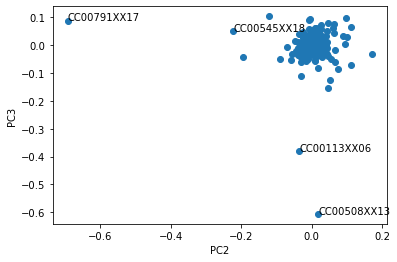

In [26]:
from scipy import stats
zscores=np.abs(stats.zscore(european_ID_dataset_term.loc[:,('Anc_PC2','Anc_PC3')].astype('float64'),axis=0))
outliers=np.where(zscores>=3.5)[0]#remove anything more than 2.5 st. deviation from the mean.

#removing outliers using the ancestrial PCA
fig,ax=plt.subplots()
ax.scatter(european_ID_dataset_term.loc[:,'Anc_PC2'],european_ID_dataset_term.loc[:,'Anc_PC3'])
for i,txt in enumerate(european_ID_dataset_term.loc[outliers,'ID']):
    ax.annotate(txt,(european_ID_dataset_term.loc[outliers[i],'Anc_PC2'],european_ID_dataset_term.loc[outliers[i],'Anc_PC3']))
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')

european_ID_dataset_without_outliers=european_ID_dataset_term.drop(outliers).reset_index(drop=True)

In [37]:
# european_ID_dataset_without_outliers.to_csv('./preprocessed_data/volumetric/term/european_ID_dataset_without_outlier_term.csv',index=False)

In [85]:
european_volumetric_AAL_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,4027:4120])
european_volumetric_Imperial_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,4120:4207])
european_PRS_schizophrenia=np.asarray(european_ID_dataset_without_outliers.iloc[:,4207:4218])
european_ancestral_PCA=np.asarray(european_ID_dataset_without_outliers.iloc[:,4218:4228])

In [89]:
#extracting ages, total volume, gender
european_age_at_scan=np.asarray(european_ID_dataset_without_outliers.iloc[:,3])
european_gestational_age=np.asarray(european_ID_dataset_without_outliers.iloc[:,4])
european_total_volume=np.asarray(european_ID_dataset_without_outliers.loc[:,'17 TOTAL BRAIN TISSUE VOLUME (mm3)'])
european_icv=np.asarray(european_ID_dataset_without_outliers.loc[:,'17 ICV (all except bone)'])

## 1.2.1 Removing outliers (Diffusion)

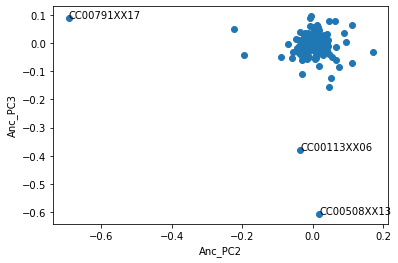

In [24]:
from scipy import stats
zscores=np.abs(stats.zscore(european_ID_diffusion_dataset_term.loc[:,('Anc_PC2','Anc_PC3')].astype('float64'),axis=0))
outliers=np.where(zscores>=3.5)[0]#remove anything more than 3.5 st. deviation from the mean.

#removing outliers using the ancestrial PCA
fig,ax=plt.subplots()
ax.scatter(european_ID_diffusion_dataset_term.loc[:,'Anc_PC2'],european_ID_diffusion_dataset_term.loc[:,'Anc_PC3'])
for i,txt in enumerate(european_ID_diffusion_dataset_term.loc[outliers,'ID']):
    ax.annotate(txt,(european_ID_diffusion_dataset_term.loc[outliers[i],'Anc_PC2'],european_ID_diffusion_dataset_term.loc[outliers[i],'Anc_PC3']))
ax.set_xlabel('Anc_PC2')
ax.set_ylabel('Anc_PC3')

european_ID_diffusion_dataset_without_outliers=european_ID_diffusion_dataset_term.drop(outliers).reset_index(drop=True)

In [25]:
european_ID_diffusion_dataset_without_outliers.to_csv('./preprocessed_data/diffusion/european_ID_diffusion_dataset_term_without_outliers.csv',index=False)

In [30]:
european_diffusion_matrix=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,5:4010])
european_diffusion_ancestral_PCA=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,4218:4228])
european_diffusion_PRS_schizophrenia=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,4207:4218])

In [31]:
#extracting ages, total volume, gender
european_diffusion_age_at_scan=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,4])
european_diffusion_gestational_age=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,3])
european_diffusion_gender=np.asarray(european_ID_diffusion_dataset_without_outliers.iloc[:,2])

## 1.3 Adjusting for covariates (Volumetric)

Text(0, 0.5, 'PC3')

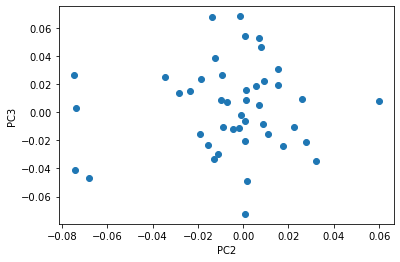

In [90]:
plt.scatter(european_ancestral_PCA[:,1],european_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

For PRS: I adjusted for the first 3 ancestral PCs.

For volumetric data: I adjusted for age at scan, at birth, intracranial volume, and total volume.

In [91]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_PRS_schizophrenia,european_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_volumetric_AAL_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_AAL_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_AAL_matrix=adjusted_european_volumetric_AAL_matrix.astype('float64')

adjusted_european_volumetric_Imperial_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_Imperial_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_Imperial_matrix=adjusted_european_volumetric_Imperial_matrix.astype('float64')

#remove the CSF, Extracranial and Intracranial volume from adjusted_european_volumetric_Imperial_matrix
adjusted_european_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[82,83,84],axis=1)
Imperial_label=np.delete(Imperial_label,[82,83,84],axis=0)

#remove the WM from adjusted_european_structural_schizophrenia
adjusted_european_GM_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=1)
Imperial_GM_labels=np.delete(Imperial_label,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=0)

## 1.3.1 Adjusting covariates (Diffusion)

Text(0, 0.5, 'PC3')

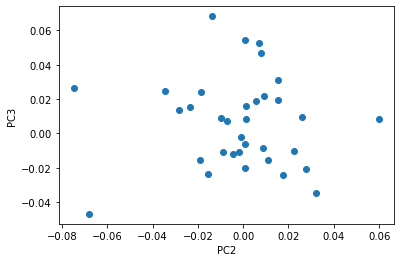

In [33]:
plt.scatter(european_diffusion_ancestral_PCA[:,1],european_diffusion_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

In [34]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_diffusion_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_PRS_schizophrenia,european_diffusion_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_diffusion_PRS_schizophrenia=adjusted_european_diffusion_PRS_schizophrenia.astype('float64')

adjusted_european_diffusion_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)
adjusted_european_diffusion_matrix=adjusted_european_diffusion_matrix.astype('float64')

## 1.4. Saving the processed data (Volumetric)

In [96]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [22]:
# save_to_npy('./preprocessed_data/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [97]:
save_to_npy('./preprocessed_data/volumetric/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [99]:
! ls preprocessed_data/volumetric/preterm/

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy


## 1.4.1 Saving the processed data (Diffusion)

In [25]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [35]:
save_to_npy('./preprocessed_data/diffusion/preterm/',adjusted_european_diffusion_PRS_schizophrenia,adjusted_european_diffusion_matrix,european_diffusion_PRS_schizophrenia,european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)

array(['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R',
       'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L',
       'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R',
       'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L',
       'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R',
       'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L',
       'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R',
       'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R',
       'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R',
       'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R',
       'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L',
       'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R',
       'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L',
       'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R',
       'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R',
   